## 1. albumentations

In [1]:
import pandas as pd
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import joblib

In [2]:
class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'./input/train_images/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:,:,np.newaxis]
        
        label_1 = self.csv.iloc[index].grapheme_root
        label_2 = self.csv.iloc[index].vowel_diacritic
        label_3 = self.csv.iloc[index].consonant_diacritic
        
        return (torch.tensor(img, dtype=torch.float).permute(2,0,1), torch.tensor(label_1, dtype= torch.long),
               torch.tensor(label_2, dtype= torch.long), torch.tensor(label_3, dtype= torch.long))

In [29]:
img = joblib.load(f'./input/train_images/Train_314.pkl')
img = img.reshape(137, 236).astype(np.uint8)
img = 255 - img
img = img[:,:,np.newaxis]

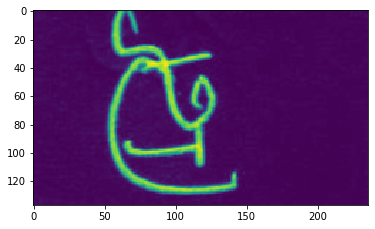

In [12]:
plt.imshow(img[:,:,0])

In [30]:
# pytorch 에 맞게 이미지 변형 (RGB channel)
img = np.repeat(img,3,2)
img.shape

(137, 236, 3)

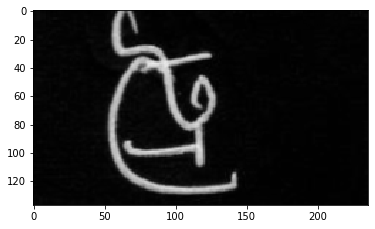

In [19]:
plt.imshow(img)

In [21]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

In [146]:
train_transforms = Compose([
        #RandomRotate90(),
        #Flip(),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=1.0)

In [77]:
img1 = train_transforms(image=img)['image']
img1

array([[[13, 13, 13],
        [ 5,  5,  5],
        [10, 10, 10],
        ...,
        [ 6,  6,  6],
        [ 4,  4,  4],
        [ 4,  4,  4]],

       [[ 7,  7,  7],
        [ 5,  5,  5],
        [12, 12, 12],
        ...,
        [ 5,  5,  5],
        [ 6,  6,  6],
        [ 2,  2,  2]],

       [[ 9,  9,  9],
        [12, 12, 12],
        [ 9,  9,  9],
        ...,
        [ 4,  4,  4],
        [ 9,  9,  9],
        [ 3,  3,  3]],

       ...,

       [[ 6,  6,  6],
        [ 6,  6,  6],
        [ 1,  1,  1],
        ...,
        [10, 10, 10],
        [ 6,  6,  6],
        [ 7,  7,  7]],

       [[11, 11, 11],
        [ 7,  7,  7],
        [11, 11, 11],
        ...,
        [ 2,  2,  2],
        [ 3,  3,  3],
        [ 1,  1,  1]],

       [[ 5,  5,  5],
        [ 7,  7,  7],
        [12, 12, 12],
        ...,
        [ 8,  8,  8],
        [ 0,  0,  0],
        [ 2,  2,  2]]], dtype=uint8)

Text(0.5, 1.0, 'transformed')

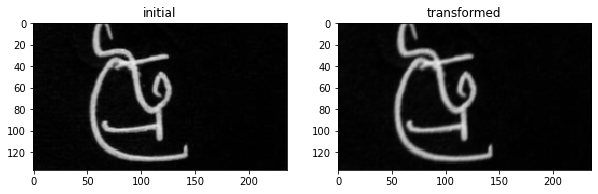

In [137]:
img1 = train_transforms(image=img)['image']

f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img1)

ax[0].set_title('initial')
ax[1].set_title('transformed')

### 모델에 적용하기

In [139]:
import pretrainedmodels
import torch.nn as nn
from albumentations.pytorch import ToTensor

In [141]:
img.shape # 채널 바꿔야함 근데 albumentation.pytorch ToTensor 쓰면 간단하게 해결가능

(137, 236, 3)

In [147]:
train_transforms = Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        #Rotate(20),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ToTensor()  # pytorch 형식 채널 바꾸기
    ], p=1.0)

In [148]:
img1.shape  # pytorch 형식이 아님 (이전 버전)

(137, 236, 3)

torch.Size([3, 137, 236])


Text(0.5, 1.0, 'transformed')

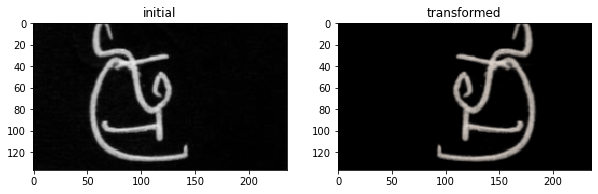

In [150]:
img2 = train_transforms(image=img)['image']
print(img2.shape)

f, ax = plt.subplots(1,2,figsize=(10,16))
ax[0].imshow(img)
ax[1].imshow(img2.permute(1,2,0))

ax[0].set_title('initial')
ax[1].set_title('transformed')

In [152]:
img2.permute(1,2,0).shape

torch.Size([137, 236, 3])

In [ ]:
model_name = 'resnet34'
backbone = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

# inputchannel 1로 바꾸기
backbone.conv1 = nn.Conv2d(1,64,7,2,3, bias=False)

# lastLinear 바꾸기 - out_features
in_features = backbone.last_linear.in_features
backbone.last_linear = nn.Linear(in_features, 186)
backbone

In [154]:
# normalize 되어있다!!
img2, img2.max()

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]), tensor(0.8824))

### Dataset 변경

In [170]:
class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width, transform):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        self.transform = transform
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'./input/train_images/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:,:,np.newaxis]
        img = np.repeat(img, 3, 2)
        
        if self.transform is not None:
            img = self.transform(image=img)['image']
        
        label_1 = self.csv.iloc[index].grapheme_root
        label_2 = self.csv.iloc[index].vowel_diacritic
        label_3 = self.csv.iloc[index].consonant_diacritic
        
        return img, label_1, label_2, label_3

In [164]:
index = 0
HEIGHT = 137
WIDTH = 236

df_train = pd.read_csv('./input/train.csv')
df_train['fold'] = pd.read_csv('./input/df_folds.csv')['fold']
trn_fold = [i for i in range(6) if i not in [5]]
vld_fold = [5]

trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [171]:
trn_dataset = BengaliDataset(csv=df_train.loc[trn_idx], img_height = HEIGHT, img_width=WIDTH, transform=train_transforms)

In [176]:
trn_dataset[0][0].shape

torch.Size([3, 137, 236])

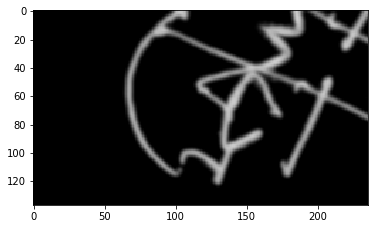

In [215]:
plt.imshow(trn_dataset[0][0].permute(1,2,0))